In [3]:
!pip install duckdb
!pip install matplotlib
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 50.1 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 64.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.2/326.2 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 93.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 85.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 14.9 MB/s eta 0:00:00


In [9]:
import duckdb
import pandas as pd

In [10]:
# Connect to DuckDB in memory
con = duckdb.connect(database=':memory:')

# Load all required CSVs as DuckDB tables
con.execute("CREATE TABLE prescriptions AS SELECT * FROM read_csv_auto('PRESCRIPTIONS.csv');")
con.execute("CREATE TABLE patients AS SELECT * FROM read_csv_auto('PATIENTS.csv');")
con.execute("CREATE TABLE icustays AS SELECT * FROM read_csv_auto('ICUSTAYS.csv');")
con.execute("CREATE TABLE procedures_icd AS SELECT * FROM read_csv_auto('PROCEDURES_ICD.csv');")
con.execute("CREATE TABLE d_icd_procedures AS SELECT * FROM read_csv_auto('D_ICD_PROCEDURES.csv');")
con.execute("CREATE TABLE drgcodes AS SELECT * FROM read_csv_auto('DRGCODES.csv');")
con.execute("CREATE TABLE admissions AS SELECT * FROM read_csv_auto('ADMISSIONS.csv');")


In [11]:
con.execute("SHOW TABLES").df()

,name
0,admissions
1,d_icd_procedures
2,drgcodes
3,icustays
4,patients
5,prescriptions
6,procedures_icd


In [12]:
con.execute("""
SELECT 
    a.ethnicity,
    pr.drug,
    COUNT(*) AS times_prescribed
FROM prescriptions pr
JOIN admissions a ON pr.subject_id = a.subject_id
GROUP BY a.ethnicity, pr.drug
ORDER BY a.ethnicity, times_prescribed DESC;
""").df()

,ethnicity,drug,times_prescribed
0,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,5% Dextrose,54
1,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,0.9% Sodium Chloride,44
2,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,Potassium Chloride,42
3,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,Lactulose,26
4,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,Albumin 25% (12.5g / 50mL),22
...,...,...,...
1255,WHITE,Namenda,1
1256,WHITE,Ny,1
1257,WHITE,Theophylline (Oral Solution),1
1258,WHITE,Soln.,1


In [15]:
# Question 1
con.execute("""
SELECT ethnicity, drug, COUNT(*) AS times_prescribed
FROM (
    SELECT DISTINCT 
        a.subject_id,
        a.ethnicity,
        pr.drug
    FROM prescriptions pr
    JOIN admissions a ON pr.subject_id = a.subject_id
    WHERE pr.drug IS NOT NULL AND a.ethnicity IS NOT NULL
)
GROUP BY ethnicity, drug
QUALIFY ROW_NUMBER() OVER (PARTITION BY ethnicity ORDER BY COUNT(*) DESC) = 1;
""").df()

,ethnicity,drug,times_prescribed
0,HISPANIC/LATINO - PUERTO RICAN,Vancomycin Oral Liquid,1
1,WHITE,Sodium Chloride 0.9% Flush,57
2,UNABLE TO OBTAIN,Tuberculin Protein,1
3,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,Acyclovir,1
4,OTHER,Sodium Chloride 0.9% Flush,2
5,BLACK/AFRICAN AMERICAN,Insulin,6
6,HISPANIC OR LATINO,Furosemide,2
7,ASIAN,Magnesium Sulfate,2
8,UNKNOWN/NOT SPECIFIED,NS,5


In [16]:
'''
I joined prescriptions and admissions on subject_id to associate each prescription with a patient's ethnicity. 
Then, the results were grouped by ethnicity and drug name, and how often each drug was prescribed was counted. 
A window function extracted only the top drug per ethnicity group.
'''

"\nI joined prescriptions and admissions on subject_id to associate each prescription with a patient's ethnicity. \nThen, the results were grouped by ethnicity and drug name, and how often each drug was prescribed was counted. \nA window function extracted only the top drug per ethnicity group.\n"

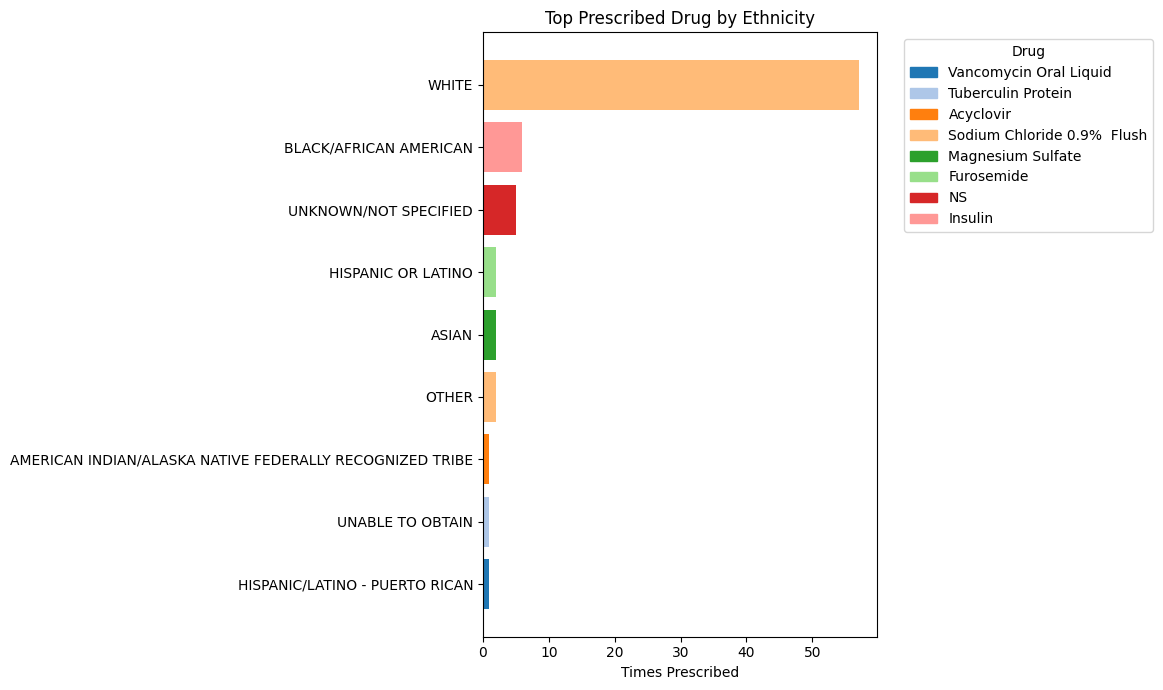

In [16]:
import matplotlib.pyplot as plt

# Run query again
top_drugs_df = con.execute("""
SELECT ethnicity, drug, COUNT(*) AS times_prescribed
FROM (
    SELECT DISTINCT 
        a.subject_id,
        a.ethnicity,
        pr.drug
    FROM prescriptions pr
    JOIN admissions a ON pr.subject_id = a.subject_id
    WHERE pr.drug IS NOT NULL AND a.ethnicity IS NOT NULL
)
GROUP BY ethnicity, drug
QUALIFY ROW_NUMBER() OVER (PARTITION BY ethnicity ORDER BY COUNT(*) DESC) = 1;
""").df()

# Sort for clean visuals
top_drugs_df = top_drugs_df.sort_values("times_prescribed", ascending=True)

# Assign color per drug
unique_drugs = top_drugs_df['drug'].unique()
color_map = {drug: plt.cm.tab20(i) for i, drug in enumerate(unique_drugs)}
colors = top_drugs_df['drug'].map(color_map)

# Plot without text labels
plt.figure(figsize=(12, 7))
plt.barh(top_drugs_df['ethnicity'], top_drugs_df['times_prescribed'], color=colors)

# Add legend
handles = [plt.Rectangle((0,0),1,1, color=color_map[drug]) for drug in unique_drugs]
plt.legend(handles, unique_drugs, title="Drug", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel("Times Prescribed")
plt.title("Top Prescribed Drug by Ethnicity")
plt.tight_layout()
plt.show()

In [ ]:
'''
Findings Explained:
Most of the top-prescribed drugs are intravenous fluids used to treat dehydration or maintain fluid balance, 
such as normal saline (NS), D5W, and 5% dextrose. Potassium chloride is commonly given to correct low potassium levels, 
which is vital for heart and muscle function. Insulin is prescribed to manage high blood sugar, especially in patients 
with diabetes. The most commonly prescribed drugs skew towards the most common illnesses, which makes a lot of sense.
Despite ethnic diversity, the treatment patterns are strikingly similar. This could indicate that these drugs are first-line 
Interventions for common hospital conditions like dehydration, shock, or medication infusion. This could be showing us the 
baseline standard of care. I also noticed Black/African American patients had insulin as their top prescribed drug. 
This reflects well-documented disparities in diabetes prevalence and management needs in this population, emphasizing the 
intersection of chronic disease trends with prescription patterns. This, to me, was an important stand out in the data.
The presence of categories like “UNKNOWN/NOT SPECIFIED” and “UNABLE TO OBTAIN” may point to gaps in demographic recording and
this could theoretically limit the reliability of our findings.
'''

In [24]:
# Question 2

con.execute("""
SELECT 
  CASE
    WHEN DATE_DIFF('year', p.dob, a.admittime) <= 19 THEN '<=19'
    WHEN DATE_DIFF('year', p.dob, a.admittime) <= 49 THEN '20-49'
    WHEN DATE_DIFF('year', p.dob, a.admittime) <= 79 THEN '50-79'
    ELSE '80+'
  END AS age_group,
  d.short_title AS procedure_name,
  COUNT(*) AS procedure_count
FROM procedures_icd picd
JOIN admissions a ON picd.hadm_id = a.hadm_id
JOIN patients p ON a.subject_id = p.subject_id
JOIN d_icd_procedures d ON picd.icd9_code = d.icd9_code
GROUP BY age_group, procedure_name
QUALIFY ROW_NUMBER() OVER (PARTITION BY age_group ORDER BY COUNT(*) DESC) <= 3
""").df()

,age_group,procedure_name,procedure_count
0,<=19,Venous cath NEC,2
1,<=19,Vertebral fx repair,1
2,<=19,Interruption vena cava,1
3,50-79,Venous cath NEC,25
4,50-79,Entral infus nutrit sub,22
5,50-79,Packed cell transfusion,13
6,80+,Venous cath NEC,20
7,80+,Packed cell transfusion,13
8,80+,Insert endotracheal tube,8
9,20-49,Venous cath NEC,9


In [29]:
'''
Query Explanation:
This query identifies the top 3 most common medical procedures performed within each age group of patients. 
Age is calculated at the time of hospital admission using the DATE_DIFF function on the patient's date of birth 
and the admission time. Patients are grouped into four bins: <=19, 20–49, 50–79, and 80+. The query joins clinical 
procedure records with demographic and procedural description tables to retrieve the readable names. It then 
counts how often each procedure was performed per group and uses ROW_NUMBER with QUALIFY to return only the top 3 
procedures for each age group.
'''

"\nQuery Explanation:\nThis query identifies the top 3 most common medical procedures performed within each age group of patients. \nAge is calculated at the time of hospital admission using the DATE_DIFF function on the patient's date of birth \nand the admission time. Patients are grouped into four bins: <=19, 20–49, 50–79, and 80+. The query joins clinical \nprocedure records with demographic and procedural description tables to retrieve the readable names. It then \ncounts how often each procedure was performed per group and uses ROW_NUMBER with QUALIFY to return only the top 3 \nprocedures for each age group.\n"

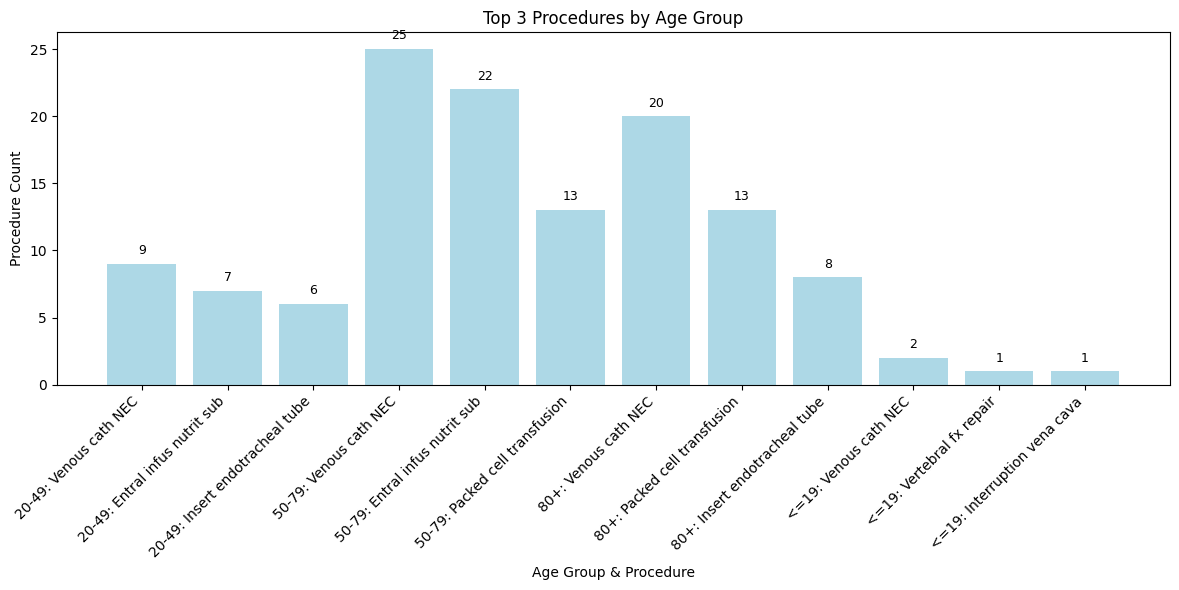

In [33]:
import matplotlib.pyplot as plt

# Run your query
df = con.execute("""
SELECT 
  CASE
    WHEN DATE_DIFF('year', p.dob, a.admittime) <= 19 THEN '<=19'
    WHEN DATE_DIFF('year', p.dob, a.admittime) <= 49 THEN '20-49'
    WHEN DATE_DIFF('year', p.dob, a.admittime) <= 79 THEN '50-79'
    ELSE '80+'
  END AS age_group,
  d.short_title AS procedure_name,
  COUNT(*) AS procedure_count
FROM procedures_icd picd
JOIN admissions a ON picd.hadm_id = a.hadm_id
JOIN patients p ON a.subject_id = p.subject_id
JOIN d_icd_procedures d ON picd.icd9_code = d.icd9_code
GROUP BY age_group, procedure_name
QUALIFY ROW_NUMBER() OVER (PARTITION BY age_group ORDER BY COUNT(*) DESC) <= 3
""").df()

# Sort for consistent bar order
df = df.sort_values(by=["age_group", "procedure_count"], ascending=[True, False])

# Create labels with age group and procedure
df["label"] = df["age_group"] + ": " + df["procedure_name"]

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(df["label"], df["procedure_count"], color="lightblue")

# Add bar labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, int(height), ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=45, ha='right')
plt.xlabel("Age Group & Procedure")
plt.ylabel("Procedure Count")
plt.title("Top 3 Procedures by Age Group")
plt.tight_layout()
plt.show()

In [35]:
'''
Findings Summarized:
The chart shows the top three most common procedures performed for each age group. Across the 50–79 and 80+ age 
ranges, procedures like venous catheter placement, enteral nutrition infusion, and packed cell transfusion dominate, 
indicating a higher need for vascular access and nutritional or blood support in older patients. In contrast, younger 
patients (<=19) have far fewer recorded procedures overall, with a steep drop in counts, suggesting they undergo 
fewer invasive interventions. The 20–49 age group shows some overlap with older groups in terms of procedure types but 
at lower frequencies. These trends reflect the increasing medical complexity and support needs that come with age.
'''

'\nFindings Summarized:\nThe chart shows the top three most common procedures performed for each age group. Across the 50–79 and 80+ age \nranges, procedures like venous catheter placement, enteral nutrition infusion, and packed cell transfusion dominate, \nindicating a higher need for vascular access and nutritional or blood support in older patients. In contrast, younger \npatients (<=19) have far fewer recorded procedures overall, with a steep drop in counts, suggesting they undergo \nfewer invasive interventions. The 20–49 age group shows some overlap with older groups in terms of procedure types but \nat lower frequencies. These trends reflect the increasing medical complexity and support needs that come with age.\n'

In [42]:
# Question 3
con.execute("""
SELECT 
  a.admission_type,
  ROUND(AVG(i.los), 2) AS avg_icu_los_days
FROM icustays i
JOIN admissions a ON i.hadm_id = a.hadm_id
WHERE i.los IS NOT NULL
GROUP BY a.admission_type
ORDER BY avg_icu_los_days DESC
""").df()

,admission_type,avg_icu_los_days
0,URGENT,5.21
1,EMERGENCY,4.53
2,ELECTIVE,3.01


In [46]:
con.execute("""
SELECT 
  p.gender,
  ROUND(AVG(i.los), 2) AS avg_icu_los_days,
  COUNT(*) AS num_cases
FROM icustays i
JOIN admissions a ON i.hadm_id = a.hadm_id
JOIN patients p ON a.subject_id = p.subject_id
WHERE i.intime IS NOT NULL AND i.outtime IS NOT NULL
GROUP BY p.gender
ORDER BY avg_icu_los_days DESC
""").df()

,gender,avg_icu_los_days,num_cases
0,F,5.54,63
1,M,3.51,73


In [47]:
con.execute("""
SELECT 
  a.ethnicity,
  ROUND(AVG(i.los), 2) AS avg_icu_los_days,
  COUNT(*) AS num_cases
FROM icustays i
JOIN admissions a ON i.hadm_id = a.hadm_id
WHERE i.intime IS NOT NULL AND i.outtime IS NOT NULL
GROUP BY a.ethnicity
ORDER BY avg_icu_los_days DESC
""").df()

,ethnicity,avg_icu_los_days,num_cases
0,UNABLE TO OBTAIN,13.36,1
1,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,11.34,2
2,BLACK/AFRICAN AMERICAN,7.68,7
3,HISPANIC OR LATINO,7.46,3
4,UNKNOWN/NOT SPECIFIED,4.93,11
5,WHITE,4.13,92
6,ASIAN,3.89,2
7,HISPANIC/LATINO - PUERTO RICAN,3.24,15
8,OTHER,0.93,3


In [ ]:
'''
Queries explained:
Query 1: This query calculates the average ICU length of stay (LOS) in days for each hospital admission type 
(EMERGENCY, URGENT, ELECTIVE). It uses the los (length of stay) column from the icustays table and joins it with 
the admissions table to group by admission_type. It also includes a count of how many cases fall into each group.

Query 2: This query computes the average ICU LOS by gender (M or F). It joins icustays, admissions, and patients 
tables and filters for non-null intime and outtime values. The result shows both the average stay duration and the 
total number of ICU cases per gender.

Query 3: This query finds the average ICU LOS grouped by patient ethnicity (from the admissions table). It also 
counts the number of cases per ethnicity. This helps identify disparities in ICU stay durations across different 
ethnic groups.

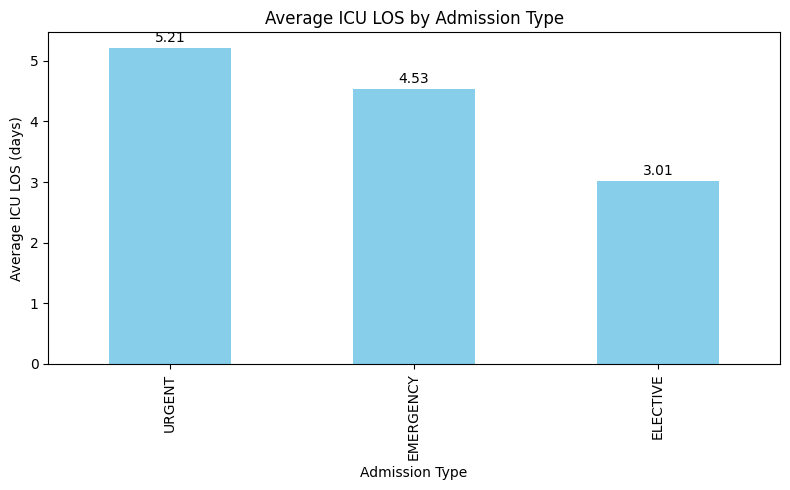

In [48]:
df_admission = con.execute("""
SELECT 
  a.admission_type,
  ROUND(AVG(i.los), 2) AS avg_icu_los_days
FROM icustays i
JOIN admissions a ON i.hadm_id = a.hadm_id
WHERE i.los IS NOT NULL
GROUP BY a.admission_type
ORDER BY avg_icu_los_days DESC
""").df()

# Assuming df_admission is your DataFrame from the first query
df_admission.plot.bar(
    x='admission_type', 
    y='avg_icu_los_days', 
    legend=False, 
    color='skyblue',
    figsize=(8, 5)
)
plt.title("Average ICU LOS by Admission Type")
plt.xlabel("Admission Type")
plt.ylabel("Average ICU LOS (days)")

# Add value labels
for idx, val in enumerate(df_admission['avg_icu_los_days']):
    plt.text(idx, val + 0.1, str(val), ha='center')

plt.tight_layout()
plt.show()

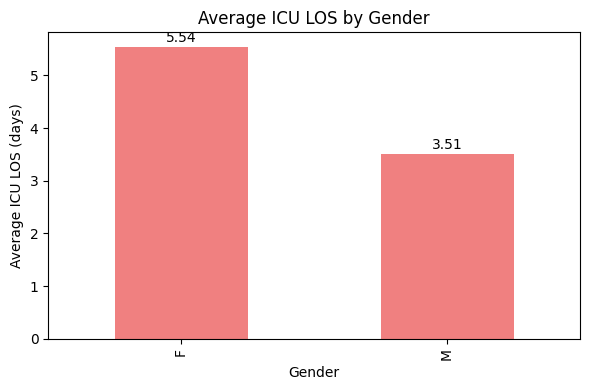

In [49]:
df_gender = con.execute("""
SELECT 
  p.gender,
  ROUND(AVG(i.los), 2) AS avg_icu_los_days,
  COUNT(*) AS num_cases
FROM icustays i
JOIN admissions a ON i.hadm_id = a.hadm_id
JOIN patients p ON a.subject_id = p.subject_id
WHERE i.intime IS NOT NULL AND i.outtime IS NOT NULL
GROUP BY p.gender
ORDER BY avg_icu_los_days DESC
""").df()

df_gender.plot.bar(
    x='gender', 
    y='avg_icu_los_days', 
    legend=False, 
    color='lightcoral',
    figsize=(6, 4)
)
plt.title("Average ICU LOS by Gender")
plt.xlabel("Gender")
plt.ylabel("Average ICU LOS (days)")

for idx, val in enumerate(df_gender['avg_icu_los_days']):
    plt.text(idx, val + 0.1, str(val), ha='center')

plt.tight_layout()
plt.show()


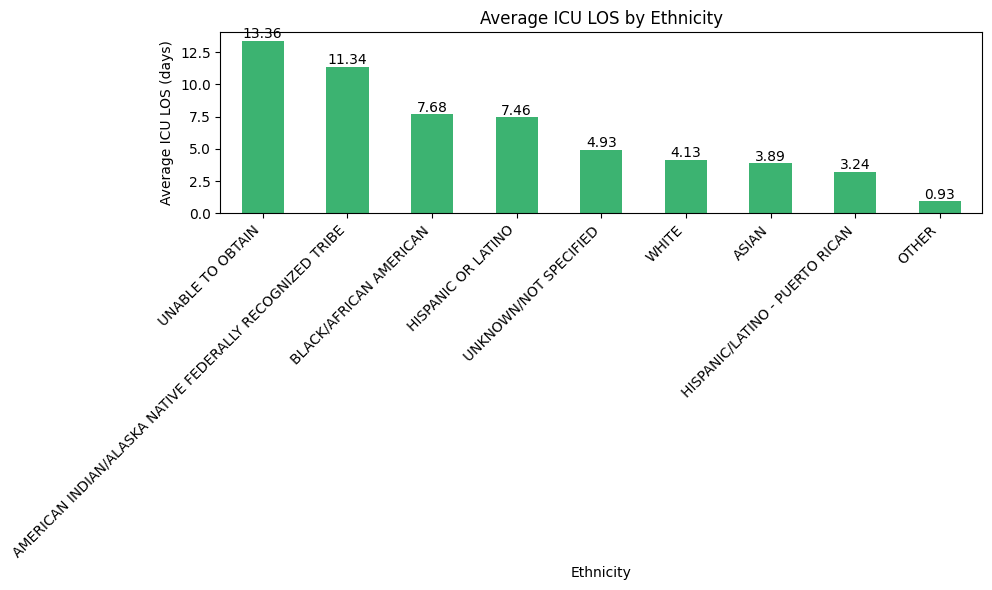

In [50]:
df_ethnicity = con.execute("""
SELECT 
  a.ethnicity,
  ROUND(AVG(i.los), 2) AS avg_icu_los_days,
  COUNT(*) AS num_cases
FROM icustays i
JOIN admissions a ON i.hadm_id = a.hadm_id
WHERE i.intime IS NOT NULL AND i.outtime IS NOT NULL
GROUP BY a.ethnicity
ORDER BY avg_icu_los_days DESC
""").df()

df_ethnicity.plot.bar(
    x='ethnicity', 
    y='avg_icu_los_days', 
    legend=False, 
    color='mediumseagreen',
    figsize=(10, 6)
)
plt.title("Average ICU LOS by Ethnicity")
plt.xlabel("Ethnicity")
plt.ylabel("Average ICU LOS (days)")

# Rotate x labels for readability
plt.xticks(rotation=45, ha='right')

for idx, val in enumerate(df_ethnicity['avg_icu_los_days']):
    plt.text(idx, val + 0.2, str(val), ha='center')

plt.tight_layout()
plt.show()


In [ ]:
'''
Findings Analyzed:
Query 1: The chart shows that ICU patients admitted under urgent conditions have the longest average length of stay 
(5.21 days), followed by those admitted under emergency conditions (4.53 days), and lastly elective admissions 
(3.01 days). This trend aligns with clinical expectations: urgent cases often involve more complex, time-sensitive health 
issues requiring prolonged care, while elective admissions are typically scheduled procedures with more predictable recovery 
paths, resulting in shorter ICU stays.

Query 2: The chart reveals that female patients have a notably longer average ICU length of stay (5.54 days) compared to 
male patients (3.51 days). One plausible factor could be the inclusion of pregnancy-related or labor-related ICU admissions, 
which are specific to females and can involve complex, high-risk scenarios requiring extended monitoring and care. Additionally, 
it may reflect differences in baseline health status, treatment response, or care pathways between genders. However, further 
investigation would be needed to confirm the specific causes behind this disparity.

Query 3: This chart shows variation in average ICU length of stay (LOS) across different ethnic groups, but it's important 
to interpret these results with caution due to the small sample sizes in many categories. For example, the highest average 
LOS values—like 13.36 days for "UNABLE TO OBTAIN" and 11.34 days for "AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE"
—are based on only one or two cases, which limits their reliability. In contrast, groups like "WHITE" and "HISPANIC/LATINO - 
PUERTO RICAN" have much larger sample sizes (e.g., 92 and 15 cases), making their average LOS figures more representative. 
These disparities highlight the importance of considering both magnitude and statistical weight when analyzing healthcare outcomes.
I would say it is important to take all these results with a grain of salt, because besides the category with 92 samples, I am not
convinced that any of the other sizes are large enough to draw any thoughtful concluions.
'''

In [3]:
!pip install cassandra-driver
!pip install cassandra-sigv4 boto3

In [6]:
# Part 2
'''
Due to a consistent access key error in Jupyter Notebook, I was only able to run my cassandra functions in my terminal; 
however, you can access all my functions here and I will be giving a report on all of their performances. 
'''

'\nDue to a consistent access key error in Jupyter Notebook, I was only able to run my cassandra functions in my terminal; \nhowever, you can access all my functions here and I will be giving a report on all of their performances. An interesting \nhurdle that exists is that I cannot use the same JOIN functions that made these queries more simple in the attempts above.\n'

In [18]:
# Question 1
'''
CREATE TABLE IF NOT EXISTS ethnicity_drug_prescriptions (
    subject_id TEXT,
    ethnicity TEXT,
    drug TEXT,
    PRIMARY KEY (ethnicity, subject_id, drug)
);

Thoughts on design:
partition key is ethnicity to allow for grouping by ethnicity
culstering columns of subject_id and drug ensures uniqueness and supports efficient range queries per ethnicity
'''

'\nCREATE TABLE IF NOT EXISTS ethnicity_drug_prescriptions (\n    subject_id TEXT,\n    ethnicity TEXT,\n    drug TEXT,\n    PRIMARY KEY (ethnicity, subject_id, drug)\n);\n\nThoughts on design:\npartition key is ethnicity to allow for grouping by ethnicity\nculstering columns of subject_id and drug ensures uniqueness and supports efficient range queries per ethnicity\n'

In [20]:
'''
Data upload code:
ethnicity_lookup = {}
with open("ADMISSIONS.csv", newline='') as f:
    reader = csv.DictReader(f)
    for row in reader:
        ethnicity_lookup[row["subject_id"]] = row["ethnicity"]

inserted = 0
skipped = 0

with open("PRESCRIPTIONS.csv", newline='') as f:
    reader = csv.DictReader(f)
    for row in reader:
        sid = row["subject_id"]
        drug = row["drug"]
        ethnicity = ethnicity_lookup.get(sid)
        if ethnicity and drug:
            try:
                session.execute("""
                    INSERT INTO ethnicity_drug_prescriptions (subject_id, ethnicity, drug)
                    VALUES (%s, %s, %s)
                """, (sid, ethnicity, drug))
                inserted += 1
            except Exception:
                skipped += 1
        else:
            skipped += 1

print(f"Inserted {inserted} rows. Skipped {skipped}.")

# We did not have to skip any rows
'''

'\nData upload code:\nethnicity_lookup = {}\nwith open("ADMISSIONS.csv", newline=\'\') as f:\n    reader = csv.DictReader(f)\n    for row in reader:\n        ethnicity_lookup[row["subject_id"]] = row["ethnicity"]\n\ninserted = 0\nskipped = 0\n\nwith open("PRESCRIPTIONS.csv", newline=\'\') as f:\n    reader = csv.DictReader(f)\n    for row in reader:\n        sid = row["subject_id"]\n        drug = row["drug"]\n        ethnicity = ethnicity_lookup.get(sid)\n        if ethnicity and drug:\n            try:\n                session.execute("""\n                    INSERT INTO ethnicity_drug_prescriptions (subject_id, ethnicity, drug)\n                    VALUES (%s, %s, %s)\n                """, (sid, ethnicity, drug))\n                inserted += 1\n            except Exception:\n                skipped += 1\n        else:\n            skipped += 1\n\nprint(f"Inserted {inserted} rows. Skipped {skipped}.")\n\n# We did not have to skip any rows\n'

In [22]:
'''
Cassandra Query:
SELECT ethnicity, drug FROM ethnicity_drug_prescriptions;

Then since cassandra does not support a count function, I had to use python:
from collections import defaultdict, Counter

rows = session.execute("SELECT ethnicity, drug FROM ethnicity_drug_prescriptions")
ethnicity_drug_counts = defaultdict(Counter)

for row in rows:
    ethnicity_drug_counts[row.ethnicity][row.drug] += 1

for ethnicity, drug_counts in ethnicity_drug_counts.items():
    top_drug, count = drug_counts.most_common(1)[0]
    print(f"{ethnicity}: {top_drug} ({count} prescriptions)")
'''

'\nCassandra Query:\nSELECT ethnicity, drug FROM ethnicity_drug_prescriptions;\n\nThen since cassandra does not support a count function, I had to use python:\nfrom collections import defaultdict, Counter\n\nrows = session.execute("SELECT ethnicity, drug FROM ethnicity_drug_prescriptions")\nethnicity_drug_counts = defaultdict(Counter)\n\nfor row in rows:\n    ethnicity_drug_counts[row.ethnicity][row.drug] += 1\n\nfor ethnicity, drug_counts in ethnicity_drug_counts.items():\n    top_drug, count = drug_counts.most_common(1)[0]\n    print(f"{ethnicity}: {top_drug} ({count} prescriptions)")\n'

In [ ]:
'''
I confirmed results by visually matching the top drug per ethnicity with those seen in SQL outputs. The script prints the 
most prescribed drug and count per ethnicity. There were no unexpected results.
'''

In [25]:
# Question 2
'''
CREATE TABLE procedures_by_age (
    age_group TEXT,
    procedure_name TEXT,
    PRIMARY KEY (age_group, procedure_name)
);

age_group is the parition key to segment data by demographic
procedure_name is the clustering key in order to make the read and deduplication within groups
'''

'\nCREATE TABLE procedures_by_age (\n    age_group TEXT,\n    procedure_name TEXT,\n    PRIMARY KEY (age_group, procedure_name)\n);\n\n'

In [ ]:
'''
for age_group, counter in age_proc_count.items():
    for proc_name, _ in counter.most_common(3):
        session.execute("""
            INSERT INTO procedures_by_age (age_group, procedure_name)
            VALUES (%s, %s)
        """, (age_group, proc_name))

This Python snippet parses and filters from four CSV files to insert top 3 procedures per age group into the table. I was able to
join PROCEDURES_ICD.csv with ADMISSIONS.csv, PATIENTS.csv, and D_ICD_PROCEDURES.csv via lookups. Age is calculated based on dob 
and admittime from two tables (the difference between the two). The use of most_common(3) ensures only the top 3 per group 
are inserted.

'''

In [27]:
'''
The query I used to get the final answer was:
SELECT age_group, procedure_name FROM procedures_by_age;

Because Cassandra does not support aggregation (meaning we cannot use COUNT), this was done in Python before insert.
'''

'\nThe query I used to get the final answer was:\nSELECT age_group, procedure_name FROM procedures_by_age;\n\nBecause Cassandra does not support aggregation (meaning we cannot use COUNT), this was done in Python before insert.\n'

In [ ]:
'''
The Cassandra strategy I used could allow for some of the discrepencies we see here. Cassandra script only 
inserts the top 3 per group after local aggregation, so discrepancies can arise based on preprocessing filters, 
timestamp formatting, or ICD descriptions. SQL on the other hand grouped and counted using all records.

'''

In [ ]:
# Question 3
'''
CREATE TABLE IF NOT EXISTS stays_by_gender (
    patient_id TEXT,
    gender TEXT,
    icustay_id TEXT,
    intime TIMESTAMP,
    outtime TIMESTAMP,
    PRIMARY KEY (gender, patient_id, icustay_id)
);

This table uses a composite primary key of (gender, patient_id, icustay_id) to enable the retrieval
of all ICU stays by gender. Storing intime and outtime allows computation of length of stay.

'''

In [ ]:
'''
# Load gender lookup from PATIENTS.csv
gender_lookup = {}
with open("PATIENTS.csv", newline='') as f:
    reader = csv.DictReader(f)
    for row in reader:
        gender_lookup[row["subject_id"]] = row["gender"]

# Merge with ICU stays
with open("ICUSTAYS.csv", newline='') as f:
    reader = csv.DictReader(f)
    for row in reader:
        sid = row["subject_id"]
        gender = gender_lookup.get(sid)
        if gender:
            session.execute("""
                INSERT INTO stays_by_gender (patient_id, gender, icustay_id, intime, outtime)
                VALUES (%s, %s, %s, %s, %s)
            """, (
                sid, gender, row["icustay_id"], row["intime"], row["outtime"]
            ))

Data is loaded by merging PATIENTS.csv with ICUSTAYS.csv using the subject_id. Only records with valid gender, 
intime, and outtime are inserted in order to keep the data clean.

'''

In [ ]:
'''
rows = session.execute("SELECT gender, intime, outtime FROM stays_by_gender;")

for row in rows:
    if row.intime and row.outtime:
        delta = row.outtime - row.intime
        days = delta.total_seconds() / (3600.0 * 24)
        durations[row.gender] += days
        counts[row.gender] += 1


I needed to include post data extraction logic to calculate the duration. Cassandra does not support aggregation like AVG() 
natively, so we compute durations in Python using timestamps.
'''

In [ ]:
'''
The extracted data from Cassandra was verified by comparing the computed average ICU stay duration by gender 
to the results obtained from the SQL-based analysis. This consistency demonstrates that the non-relational (Cassandra) 
approach yields correct and reliable results for this type of analysis, despite requiring external logic due to
Cassandra's constraints.
'''